# Transfer Wise Take Home Task

## Intro
Imagine you’ve joined a simpler version of TransferWise in the to-India team. Your team is
focussed on the EUR to INR route where customers can transfer money on that route to either
themselves or others. Because of local regulations the team hasn’t implemented any of the
other products (e.g the Borderless account) of TransferWise nor is it supporting any other
routes to INR.
The team has never had an analyst before and asked you to do the following tasks with the
following datasets (see glossary below for description of tables).


__________________________

## Task I
To see how the team is progressing, they look at their KPIs which are the amount of new
users, the number of transfers, the volume of transfers (i.e. the amount of money sent) and
revenue from transfers (i.e. the fees generated from those transfers) of transfers that have
been successfully transferred. At the moment they don’t have all of these numbers in one
place and asked you to build a single reporting table with the following requirements:

__Task: create a reporting table using SQL which allows the team to track their KPIs__

___1. We need to have the following measures:___
1. New users
2. Users
3. Transfers
4. Volume in EUR, GBP and INR
5. Revenue in EUR, GBP and INR
6. Active rates of users in relation to the total user base (active users for a period divided by the total number of users at the beginning of the period)

___2. With the following dimensions:___
1. All measures aggregated to a monthly level
2. All measures broken down by transfer types


In [4]:
import pandas as pd
import sqlite3
import numpy as np
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from dateutil.parser import parse 
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import data
conn = sqlite3.connect("case_study_(1).db")

In [6]:
# I.1.1 New Users
# To get to the new users we can use the column first_transfer_date

query = '''
with base as (
select distinct u.user_id, u.first_transfer_date, t.transfer_id, tm.transfer_type
from users u 
left join transfers t on u.first_transfer_id = t.transfer_id
left join transfers_meta tm on t.transfer_id = tm.transfer_id
where t.flag_not_test = 1
)

select 
strftime('%Y-%m',first_transfer_date) as year_month,
transfer_type,
count(distinct user_id) as new_users
from base
group by 1,2
order by 1 desc
'''
df_new_users = pd.read_sql_query(query, conn)
df_new_users

year_month transfer_type  new_users
0      2018-12      Business         46
1      2018-12      Personal        776
2      2018-11      Business         38
3      2018-11      Personal        730
4      2018-10      Business         55
..         ...           ...        ...
108    2014-02      Personal         48
109    2014-01      Personal         38
110    2013-12      Personal         26
111    2013-11      Personal         12
112    2013-10      Personal          6

[113 rows x 3 columns]

In [7]:
# I.1.2 Users

query = '''
with new_users as (
select distinct u.user_id, u.first_transfer_date, t.transfer_id, tm.transfer_type
from users u 
left join transfers t on u.first_transfer_id = t.transfer_id
left join transfers_meta tm on t.transfer_id = tm.transfer_id
where t.flag_not_test = 1
)

, active_users_agg as (
select 
strftime('%Y-%m',first_transfer_date) as year_month,
transfer_type,
count(distinct user_id) as new_users
from new_users
group by 1,2
order by 1 desc
)

select a.*,SUM(new_users) OVER (ORDER BY year_month asc) as total_users
from active_users_agg a
'''
df_users = pd.read_sql_query(query, conn)
df_users

year_month transfer_type  new_users  total_users
0      2013-10      Personal          6            6
1      2013-11      Personal         12           18
2      2013-12      Personal         26           44
3      2014-01      Personal         38           82
4      2014-02      Personal         48          130
..         ...           ...        ...          ...
108    2018-10      Personal        865        26579
109    2018-11      Business         38        27347
110    2018-11      Personal        730        27347
111    2018-12      Business         46        28169
112    2018-12      Personal        776        28169

[113 rows x 4 columns]

In [8]:
# I.1.3 Transfers
query = '''
with base as (
select distinct t.user_id, t.created_at, t.transfer_id, tm.transfer_type
from transfers t
left join transfers_meta tm on t.transfer_id = tm.transfer_id
where t.flag_not_test = 1
)

select 
strftime('%Y-%m',created_at) as year_month,
transfer_type,
count(distinct transfer_id) as transfers
from base
group by 1,2
order by 1 desc

'''
df_transfers = pd.read_sql_query(query, conn)
df_transfers

year_month transfer_type  transfers
0      2018-12      Business       1076
1      2018-12      Personal      19628
2      2018-11      Business        981
3      2018-11      Personal      17533
4      2018-10      Business       1122
..         ...           ...        ...
110    2014-02      Personal        110
111    2014-01      Personal        114
112    2013-12      Personal         68
113    2013-11      Personal         60
114    2013-10      Personal         14

[115 rows x 3 columns]

In [9]:
# I.1.4 Volume in EUR, GBP and INR

query = '''
with base as (
select distinct t.user_id, date(t.created_at) created_at, t.transfer_id, tm.transfer_type,
t.transfer_value as transfer_value_eur,
t.source_currency, t.target_currency, fx_gbp.rate as rate_eur_gbp, fx_gbp.inverse_rate as inverse_rate_eur_gbp,
t.transfer_value*fx_gbp.inverse_rate as transfer_value_gbp,
fx_inr.rate as rate_inr_gbp, fx_inr.inverse_rate as inverse_rate_inr_gbp,
(t.transfer_value*fx_gbp.inverse_rate)*fx_inr.inverse_rate as transfer_value_inr
from transfers t
left join transfers_meta tm on t.transfer_id = tm.transfer_id
left join fx_rates fx_gbp on date(t.created_at) = fx_gbp.currency_date and t.source_currency = fx_gbp.source_currency
and fx_gbp.target_currency = 'GBP'
left join fx_rates fx_inr on date(t.created_at) = fx_inr.currency_date
and fx_inr.target_currency = 'GBP' and fx_inr.source_currency = 'INR'
where t.flag_not_test = 1
)


select 
strftime('%Y-%m',created_at) as year_month,
transfer_type,
sum(transfer_value_eur) as transfer_value_eur,
sum(transfer_value_gbp) as transfer_value_gbp,
sum(transfer_value_inr) as transfer_value_inr
from base
group by 1,2
order by 1 desc
'''
df_vol = pd.read_sql_query(query, conn)
df_vol

year_month transfer_type  transfer_value_eur  transfer_value_gbp  \
0      2018-12      Business             5343580        5.959794e+06   
1      2018-12      Personal            18967356        2.115621e+07   
2      2018-11      Business             4850567        5.513850e+06   
3      2018-11      Personal            16960138        1.926924e+07   
4      2018-10      Business             5658745        6.411979e+06   
..         ...           ...                 ...                 ...   
110    2014-02      Personal              159706                 NaN   
111    2014-01      Personal              158711                 NaN   
112    2013-12      Personal               93305                 NaN   
113    2013-11      Personal               84507                 NaN   
114    2013-10      Personal               21132                 NaN   

     transfer_value_inr  
0          5.340085e+08  
1          1.896026e+09  
2          5.129096e+08  
3          1.789914e+09  
4          6.145070e+08  
..                  ...  
110                 NaN  
111                 NaN  
112                 NaN  
113                 NaN  
114                 NaN  

[115 rows x 5 columns]

In [10]:
# I.1.5 Revenue in EUR, GBP and INR

query = '''
with base as (
select distinct t.user_id, date(t.created_at) created_at, t.transfer_id, tm.transfer_type,
t.fee_value as revenue_value_eur,
t.source_currency, t.target_currency, fx_gbp.rate as rate_eur_gbp, fx_gbp.inverse_rate as inverse_rate_eur_gbp,
t.fee_value*fx_gbp.inverse_rate as revenue_value_gbp,
fx_inr.rate as rate_inr_gbp, fx_inr.inverse_rate as inverse_rate_inr_gbp,
(t.fee_value*fx_gbp.inverse_rate)*fx_inr.inverse_rate as revenue_value_inr
from transfers t
left join transfers_meta tm on t.transfer_id = tm.transfer_id
left join fx_rates fx_gbp on date(t.created_at) = fx_gbp.currency_date and t.source_currency = fx_gbp.source_currency
and fx_gbp.target_currency = 'GBP'
left join fx_rates fx_inr on date(t.created_at) = fx_inr.currency_date
and fx_inr.target_currency = 'GBP' and fx_inr.source_currency = 'INR'
where t.flag_not_test = 1
)


select 
strftime('%Y-%m',created_at) as year_month,
transfer_type,
sum(revenue_value_eur) as revenue_value_eur,
sum(revenue_value_gbp) as revenue_value_gbp,
sum(revenue_value_inr) as revenue_value_inr
from base
group by 1,2
order by 1 desc

'''
df_rev = pd.read_sql_query(query, conn)
df_rev

year_month transfer_type  revenue_value_eur  revenue_value_gbp  \
0      2018-12      Business         45954.7880       51254.230706   
1      2018-12      Personal        163119.2616      181943.384193   
2      2018-11      Business         42053.0553       47804.915159   
3      2018-11      Personal        146982.8044      166999.490607   
4      2018-10      Business         49231.0815       55784.221350   
..         ...           ...                ...                ...   
110    2014-02      Personal          1421.3834                NaN   
111    2014-01      Personal          1412.5279                NaN   
112    2013-12      Personal           839.7450                NaN   
113    2013-11      Personal           760.5630                NaN   
114    2013-10      Personal           190.1880                NaN   

     revenue_value_inr  
0         4.592473e+06  
1         1.630582e+07  
2         4.447388e+06  
3         1.551424e+07  
4         5.346211e+06  
..                 ...  
110                NaN  
111                NaN  
112                NaN  
113                NaN  
114                NaN  

[115 rows x 5 columns]

In [11]:
# I.1.6 Active rates of users in relation to the total user base 
# (active users for a period divided by the total number of users at the beginning of the period)

query = '''
-- Active Users -- 

with active_users as (
select distinct t.user_id, t.created_at, t.transfer_id, tm.transfer_type
from transfers t
left join transfers_meta tm on t.transfer_id = tm.transfer_id
where t.flag_not_test = 1
)

, active_users_agg as (
select 
strftime('%Y-%m',created_at) as year_month,
transfer_type,
count(distinct user_id) as users
from active_users
group by 1,2
order by 1 desc)

-- Users --

, new_users as (
select distinct u.user_id, u.first_transfer_date, t.transfer_id, tm.transfer_type
from users u 
left join transfers t on u.first_transfer_id = t.transfer_id
left join transfers_meta tm on t.transfer_id = tm.transfer_id
where t.flag_not_test = 1
)

, new_users_agg as (
select 
strftime('%Y-%m',first_transfer_date) as year_month,
transfer_type,
count(distinct user_id) as new_users
from new_users
group by 1,2
order by 1 desc
)

, total_users as (
select a.*,SUM(new_users) OVER (ORDER BY year_month asc) as total_users,
ROW_NUMBER() OVER (partition by transfer_type ORDER BY year_month desc) as rn
from new_users_agg a
)

-- End of last month users are the beginning of the next month users
, eom_users as (
select a.*, b.rn as rn_1, b.total_users as early_month_total_users
from total_users a
left join total_users b on a.transfer_type = b.transfer_type and a.rn+1 = b.rn
)

select a.year_month, a.transfer_type, a.total_users, a.early_month_total_users, b.users as active_users,
(cast(b.users as float)/cast(a.early_month_total_users as float))*100 as activer_user_rate
from eom_users a 
left join active_users_agg b on a.year_month = b.year_month and a.transfer_type = b.transfer_type

'''
df_au = pd.read_sql_query(query, conn)
df_au

year_month transfer_type  total_users  early_month_total_users  \
0      2013-10      Personal            6                      NaN   
1      2013-11      Personal           18                      6.0   
2      2013-12      Personal           44                     18.0   
3      2014-01      Personal           82                     44.0   
4      2014-02      Personal          130                     82.0   
..         ...           ...          ...                      ...   
108    2018-10      Personal        26579                  25659.0   
109    2018-11      Business        27347                  26579.0   
110    2018-11      Personal        27347                  26579.0   
111    2018-12      Business        28169                  27347.0   
112    2018-12      Personal        28169                  27347.0   

     active_users  activer_user_rate  
0               8                NaN  
1              25         416.666667  
2              42         233.333333  
3              66         150.000000  
4              77          93.902439  
..            ...                ...  
108          8320          32.425270  
109           444           1.670492  
110          7987          30.050040  
111           454           1.660146  
112          8448          30.891871  

[113 rows x 6 columns]

In [12]:
## Final Table

query = '''
------------------------
----- Final Table ------
------------------------

-- Volumes --

with base as (
select distinct t.user_id, date(t.created_at) created_at, t.transfer_id, tm.transfer_type,
t.transfer_value as transfer_value_eur,
t.source_currency, t.target_currency, fx_gbp.rate as rate_eur_gbp, fx_gbp.inverse_rate as inverse_rate_eur_gbp,
t.transfer_value*fx_gbp.inverse_rate as transfer_value_gbp,
fx_inr.rate as rate_inr_gbp, fx_inr.inverse_rate as inverse_rate_inr_gbp,
(t.transfer_value*fx_gbp.inverse_rate)*fx_inr.inverse_rate as transfer_value_inr
from transfers t
left join transfers_meta tm on t.transfer_id = tm.transfer_id
left join fx_rates fx_gbp on date(t.created_at) = fx_gbp.currency_date and t.source_currency = fx_gbp.source_currency
and fx_gbp.target_currency = 'GBP'
left join fx_rates fx_inr on date(t.created_at) = fx_inr.currency_date
and fx_inr.target_currency = 'GBP' and fx_inr.source_currency = 'INR'
where t.flag_not_test = 1
)

, vol as (
select 
strftime('%Y-%m',created_at) as year_month,
transfer_type,
sum(transfer_value_eur) as transfer_value_eur,
sum(transfer_value_gbp) as transfer_value_gbp,
sum(transfer_value_inr) as transfer_value_inr
from base
group by 1,2
order by 1 desc
)

-- Revenue --

, base_rev as (
select distinct t.user_id, date(t.created_at) created_at, t.transfer_id, tm.transfer_type,
t.fee_value as revenue_value_eur,
t.source_currency, t.target_currency, fx_gbp.rate as rate_eur_gbp, fx_gbp.inverse_rate as inverse_rate_eur_gbp,
t.fee_value*fx_gbp.inverse_rate as revenue_value_gbp,
fx_inr.rate as rate_inr_gbp, fx_inr.inverse_rate as inverse_rate_inr_gbp,
(t.fee_value*fx_gbp.inverse_rate)*fx_inr.inverse_rate as revenue_value_inr
from transfers t
left join transfers_meta tm on t.transfer_id = tm.transfer_id
left join fx_rates fx_gbp on date(t.created_at) = fx_gbp.currency_date and t.source_currency = fx_gbp.source_currency
and fx_gbp.target_currency = 'GBP'
left join fx_rates fx_inr on date(t.created_at) = fx_inr.currency_date
and fx_inr.target_currency = 'GBP' and fx_inr.source_currency = 'INR'
where t.flag_not_test = 1
)

, rev as (
select 
strftime('%Y-%m',created_at) as year_month,
transfer_type,
sum(revenue_value_eur) as revenue_value_eur,
sum(revenue_value_gbp) as revenue_value_gbp,
sum(revenue_value_inr) as revenue_value_inr
from base_rev
group by 1,2
order by 1 desc
)

-- Transfers --

, base_transfers as (
select distinct t.user_id, t.created_at, t.transfer_id, tm.transfer_type
from transfers t
left join transfers_meta tm on t.transfer_id = tm.transfer_id
where t.flag_not_test = 1
)

, transf as (
select 
strftime('%Y-%m',created_at) as year_month,
transfer_type,
count(distinct transfer_id) as transfers
from base_transfers
group by 1,2
order by 1 desc
)

-- New users --

, base_nu as (
select distinct u.user_id, u.first_transfer_date, t.transfer_id, tm.transfer_type
from users u 
left join transfers t on u.first_transfer_id = t.transfer_id
left join transfers_meta tm on t.transfer_id = tm.transfer_id
where t.flag_not_test = 1
)

, new_users as (
select 
strftime('%Y-%m',first_transfer_date) as year_month,
transfer_type,
count(distinct user_id) as new_users
from base_nu
group by 1,2
order by 1 desc
)

-- Users --

, total_users as (
select a.*,SUM(new_users) OVER (ORDER BY year_month asc) as total_users,
ROW_NUMBER() OVER (partition by transfer_type ORDER BY year_month desc) as rn
from new_users a
)

-- Active Users Rate -- 
, active_users as (
select distinct t.user_id, t.created_at, t.transfer_id, tm.transfer_type
from transfers t
left join transfers_meta tm on t.transfer_id = tm.transfer_id
where t.flag_not_test = 1
)

, active_users_agg as (
select 
strftime('%Y-%m',created_at) as year_month,
transfer_type,
count(distinct user_id) as users
from active_users
group by 1,2
order by 1 desc)


-- End of last month users are the beginning of the next month users
, eom_users as (
select a.*, b.rn as rn_1, b.total_users as early_month_total_users
from total_users a
left join total_users b on a.transfer_type = b.transfer_type and a.rn+1 = b.rn
)

, activer_user_rate as (
select a.year_month, a.transfer_type, a.total_users, a.early_month_total_users, b.users as active_users,
(cast(b.users as float)/cast(a.early_month_total_users as float))*100 as activer_user_rate
from eom_users a 
left join active_users_agg b on a.year_month = b.year_month and a.transfer_type = b.transfer_type
)

select a.*,
b.revenue_value_eur,
b.revenue_value_gbp,
b.revenue_value_inr,
c.transfers,
d.new_users,
e.total_users as users,
f.activer_user_rate
from vol a 
left join rev b on a.year_month = b.year_month and a.transfer_type = b.transfer_type
left join transf c on a.year_month = c.year_month and a.transfer_type = c.transfer_type
left join new_users d on a.year_month = d.year_month and a.transfer_type = d.transfer_type
left join total_users e on a.year_month = e.year_month and a.transfer_type = e.transfer_type
left join activer_user_rate f on a.year_month = f.year_month and a.transfer_type = f.transfer_type
'''
df_final = pd.read_sql_query(query, conn)
df_final

year_month transfer_type  transfer_value_eur  transfer_value_gbp  \
0      2018-12      Business             5343580        5.959794e+06   
1      2018-12      Personal            18967356        2.115621e+07   
2      2018-11      Business             4850567        5.513850e+06   
3      2018-11      Personal            16960138        1.926924e+07   
4      2018-10      Business             5658745        6.411979e+06   
..         ...           ...                 ...                 ...   
110    2014-02      Personal              159706                 NaN   
111    2014-01      Personal              158711                 NaN   
112    2013-12      Personal               93305                 NaN   
113    2013-11      Personal               84507                 NaN   
114    2013-10      Personal               21132                 NaN   

     transfer_value_inr  revenue_value_eur  revenue_value_gbp  \
0          5.340085e+08         45954.7880       51254.230706   
1          1.896026e+09        163119.2616      181943.384193   
2          5.129096e+08         42053.0553       47804.915159   
3          1.789914e+09        146982.8044      166999.490607   
4          6.145070e+08         49231.0815       55784.221350   
..                  ...                ...                ...   
110                 NaN          1421.3834                NaN   
111                 NaN          1412.5279                NaN   
112                 NaN           839.7450                NaN   
113                 NaN           760.5630                NaN   
114                 NaN           190.1880                NaN   

     revenue_value_inr  transfers  new_users    users  activer_user_rate  
0         4.592473e+06       1076       46.0  28169.0           1.660146  
1         1.630582e+07      19628      776.0  28169.0          30.891871  
2         4.447388e+06        981       38.0  27347.0           1.670492  
3         1.551424e+07      17533      730.0  27347.0          30.050040  
4         5.346211e+06       1122       55.0  26579.0           1.769360  
..                 ...        ...        ...      ...                ...  
110                NaN        110       48.0    130.0          93.902439  
111                NaN        114       38.0     82.0         150.000000  
112                NaN         68       26.0     44.0         233.333333  
113                NaN         60       12.0     18.0         416.666667  
114                NaN         14        6.0      6.0                NaN  

[115 rows x 12 columns]

_____________________________

## Task II
The team wants to do their planning soon for the next 12 months. However to make this a more effective exercise, they’d like a forecast of their volume in GBP on a monthly aggregate level by transfer type. Use the table you’ve created in the previous task and create a forecast for the next 12 months.
Suggestions:
- Set up the forecast using Python. This is an opportunity to showcase your Python coding skills (no need to make the code more complex than necessary though)
- Start with a brief EDA to identify and characterize the main drivers of volume growth. This part may influence the way you decide to set up your forecast: choice of drivers and approaches
- Apply statistical forecasting technique(s) of your choice - this is an opportunity to illustrate basic statistical modelling/data science skills and reflexes. Please explain your choice of statistical methods, evaluation metrics, parameters (if any) and please show how you evaluated your model(s) - again, no need to make it more complex than necessary, basic statistical methods applied in a clean and efficient way are perfectly fine.

Please show the Python script (or the Jupyter notebook) and the forecast results.

In [13]:
# Import KPI table
query = '''
select *
from kpis
'''
df = pd.read_sql_query(query, conn)
df.head()

year_month transfer_type  transfer_value_eur  transfer_value_gbp  \
0    2018-12      Business             5343580        5.959794e+06   
1    2018-12      Personal            18967356        2.115621e+07   
2    2018-11      Business             4850567        5.513850e+06   
3    2018-11      Personal            16960138        1.926924e+07   
4    2018-10      Business             5658745        6.411979e+06   

   transfer_value_inr  revenue_value_eur  revenue_value_gbp  \
0        5.340085e+08         45954.7880       51254.230706   
1        1.896026e+09        163119.2616      181943.384193   
2        5.129096e+08         42053.0553       47804.915159   
3        1.789914e+09        146982.8044      166999.490607   
4        6.145070e+08         49231.0815       55784.221350   

   revenue_value_inr  transfers  new_users    users  activer_user_rate  
0       4.592473e+06       1076       46.0  28169.0           1.660146  
1       1.630582e+07      19628      776.0  28169.0          30.891871  
2       4.447388e+06        981       38.0  27347.0           1.670492  
3       1.551424e+07      17533      730.0  27347.0          30.050040  
4       5.346211e+06       1122       55.0  26579.0           1.769360

In [14]:
# Close connection
conn.close()

In [15]:
df.dtypes

year_month             object
transfer_type          object
transfer_value_eur      int64
transfer_value_gbp    float64
transfer_value_inr    float64
revenue_value_eur     float64
revenue_value_gbp     float64
revenue_value_inr     float64
transfers               int64
new_users             float64
users                 float64
activer_user_rate     float64
dtype: object

In [16]:
# Generate profiling report
prof = pp.ProfileReport(df)
prof.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
prof

### Volume of Transfers - Main Drivers

Using the information provided in the profiling report, the following the main drivers of volume growth are:
- __Revenue__: the volume of revenue is highly correlated with the volume of transfers. This is logical from a business perspective, as more transfers mean more fees generated (from those transfers).
- __Transfers__: the number of transfers is highly correlated with the volume of transfers. This is valid from a business perspective, as more transfers mean more money sent.
- __Users__: the user volume (new users in particular) is highly correlated with the volume of transfers. This is legitimate from a business perspective, as more users mean more transfers.




## Causality Check

In [20]:
# Remove rows with missing values
df = df.dropna(subset=['revenue_value_gbp','new_users','transfer_value_gbp','transfers'])

In [22]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            
            p_values = [round(test_result[i+1][0][test][1],6) for i in range(maxlag)]
            
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


grangers_causation_matrix(df[['revenue_value_gbp','new_users','transfer_value_gbp','transfers']], variables = df[['revenue_value_gbp','new_users','transfer_value_gbp','transfers']].columns)

revenue_value_gbp_x  new_users_x  transfer_value_gbp_x  \
revenue_value_gbp_y              1.000000          0.0              0.000003   
new_users_y                      0.000000          1.0              0.000000   
transfer_value_gbp_y             0.000003          0.0              1.000000   
transfers_y                      0.000000          0.0              0.000000   

                      transfers_x  
revenue_value_gbp_y           0.0  
new_users_y                   0.0  
transfer_value_gbp_y          0.0  
transfers_y                   1.0

As the p-value for all features is less that the significance level of 0.05, we can reject the null hypothesis and conclude that there is causality between all features.

## Stationarity Check

In [24]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    
    # The number of lags is chosen to minimise the Akaike's Information Criterion (AIC)
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
    p = dfoutput['p-value']  
    if p > 0.05:
         print('ADF: Not Stationary')
    else:
         print('ADF: Stationary')
    
    return(dfoutput)

#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    print(kpss_output)
    
    p = kpss_output['p-value']
    if p > 0.05:
        print('KPSS: Not Stationary')
    else:
        print('KPSS: Stationary')
    
    return(kpss_output)


In [25]:
# Volume of transfers
adf = adf_test(df['transfer_value_gbp'])
kpss_vol = kpss_test(df['transfer_value_gbp'])

Results of Dickey-Fuller Test:
Test Statistic                 -4.222226
p-value                         0.000604
#Lags Used                      9.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64
ADF: Stationary
Results of KPSS Test:
Test Statistic            0.820975
p-value                   0.010000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS: Stationary


In [26]:
adf = adf_test(df['transfer_value_gbp'][df['transfer_type']=='Personal'])
kpss_vol = kpss_test(df['transfer_value_gbp'][df['transfer_type']=='Personal'])
adf = adf_test(df['transfer_value_gbp'][df['transfer_type']=='Business'])
kpss_vol = kpss_test(df['transfer_value_gbp'][df['transfer_type']=='Business'])

Results of Dickey-Fuller Test:
Test Statistic                 -2.430225
p-value                         0.133387
#Lags Used                      3.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64
ADF: Not Stationary
Results of KPSS Test:
Test Statistic            0.589455
p-value                   0.023595
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS: Stationary
Results of Dickey-Fuller Test:
Test Statistic                 -2.876864
p-value                         0.048105
#Lags Used                     11.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64
ADF: Stationary

In [27]:
# Volume of revenue
adf = adf_test(df['revenue_value_gbp'])
kpss_rev = kpss_test(df['revenue_value_gbp'])

Results of Dickey-Fuller Test:
Test Statistic                 -4.130444
p-value                         0.000862
#Lags Used                      9.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64
ADF: Stationary
Results of KPSS Test:
Test Statistic            0.819358
p-value                   0.010000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS: Stationary


In [28]:
adf = adf_test(df['revenue_value_gbp'][df['transfer_type']=='Personal'])
kpss_rev = kpss_test(df['revenue_value_gbp'][df['transfer_type']=='Personal'])
adf = adf_test(df['revenue_value_gbp'][df['transfer_type']=='Business'])
kpss_rev = kpss_test(df['revenue_value_gbp'][df['transfer_type']=='Business'])

Results of Dickey-Fuller Test:
Test Statistic                 -2.365132
p-value                         0.151820
#Lags Used                      3.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64
ADF: Not Stationary
Results of KPSS Test:
Test Statistic            0.589113
p-value                   0.023626
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS: Stationary
Results of Dickey-Fuller Test:
Test Statistic                 -2.821048
p-value                         0.055330
#Lags Used                     11.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64
ADF: Not Statio

In [29]:
# New users
adf = adf_test(df['new_users'])
kpss_nu = kpss_test(df['new_users'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.856728
p-value                         0.352683
#Lags Used                     11.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64
ADF: Not Stationary
Results of KPSS Test:
Test Statistic            0.791821
p-value                   0.010000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS: Stationary


In [30]:
adf = adf_test(df['new_users'][df['transfer_type']=='Personal'])
kpss_nu = kpss_test(df['new_users'][df['transfer_type']=='Personal'])
adf = adf_test(df['new_users'][df['transfer_type']=='Business'])
kpss_nu = kpss_test(df['new_users'][df['transfer_type']=='Business'])

Results of Dickey-Fuller Test:
Test Statistic                 -0.786011
p-value                         0.823197
#Lags Used                      5.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
ADF: Not Stationary
Results of KPSS Test:
Test Statistic            0.584357
p-value                   0.024058
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS: Stationary
Results of Dickey-Fuller Test:
Test Statistic                 -1.562039
p-value                         0.502629
#Lags Used                      5.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64
ADF: Not Statio

In [31]:
# Transfers
adf = adf_test(df['transfers'])
kpss_transf = kpss_test(df['transfers'])

Results of Dickey-Fuller Test:
Test Statistic                 -4.213841
p-value                         0.000624
#Lags Used                     13.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64
ADF: Stationary
Results of KPSS Test:
Test Statistic            0.812782
p-value                   0.010000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS: Stationary


In [32]:
adf = adf_test(df['transfers'][df['transfer_type']=='Personal'])
kpss_transf = kpss_test(df['transfers'][df['transfer_type']=='Personal'])
adf = adf_test(df['transfers'][df['transfer_type']=='Business'])
kpss_transf = kpss_test(df['transfers'][df['transfer_type']=='Business'])

Results of Dickey-Fuller Test:
Test Statistic                 -2.280566
p-value                         0.178313
#Lags Used                      8.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64
ADF: Not Stationary
Results of KPSS Test:
Test Statistic            0.577566
p-value                   0.024676
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS: Stationary
Results of Dickey-Fuller Test:
Test Statistic                 -3.049597
p-value                         0.030515
#Lags Used                     11.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64
ADF: Stationary

All features (regardless the transfer type) are stricty stationarity except the new users. The number of new users is trend stationary and we need to remove the trend to make series strictly stationary.

However, the tests for single time series by transfer type were inconclusive. Therefore, it can be a good practice to detrend the data before proceding with the modelling.

## Approach

- This problem can be treated as a multi-step multivariate time series forecast process with multiple time series (for each transfer type).
- Hence, implementing the multivariate time series forecasting technique Vector Autoregression (VAR) is the best way to get the forecast.

In [33]:
# Filter data
df_filtered = df[['year_month','transfer_type','revenue_value_gbp','new_users','transfer_value_gbp','transfers']]

# Split time series 
df_personal = df_filtered[['year_month','revenue_value_gbp','new_users','transfer_value_gbp','transfers']][df_filtered['transfer_type']=='Personal']
df_business = df_filtered[['year_month','revenue_value_gbp','new_users','transfer_value_gbp','transfers']][df_filtered['transfer_type']=='Business']

# Order Time series
df_personal = df_personal.sort_values(by=['year_month'], ascending=True).reset_index(drop=True)
df_personal = df_personal[['revenue_value_gbp','new_users','transfer_value_gbp','transfers']]

df_business = df_business.sort_values(by=['year_month'], ascending=True).reset_index(drop=True)
df_business = df_business[['revenue_value_gbp','new_users','transfer_value_gbp','transfers']]

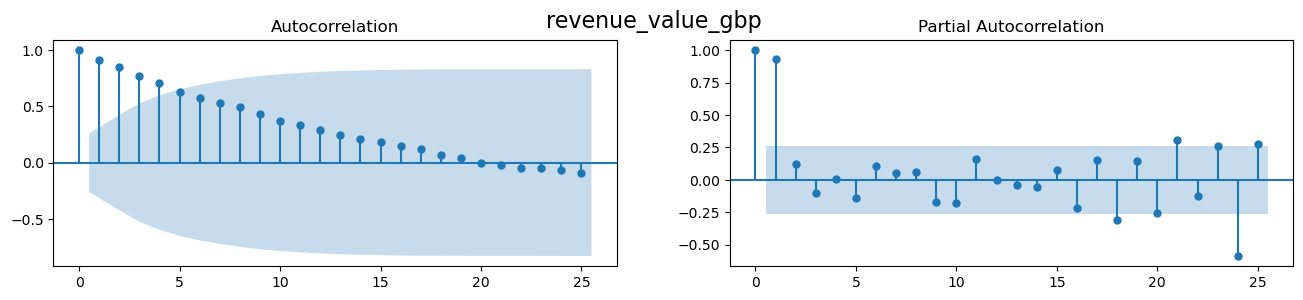

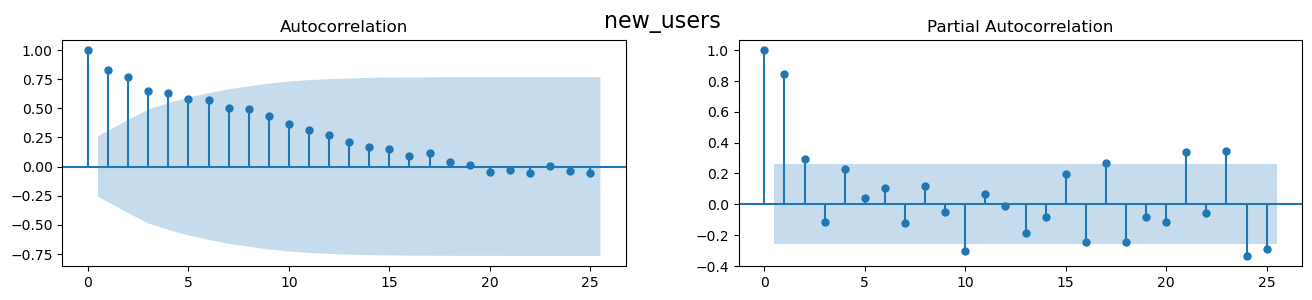

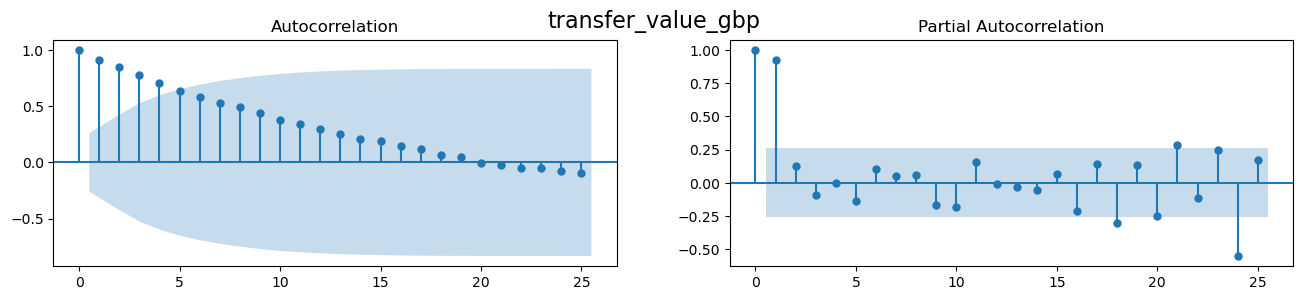

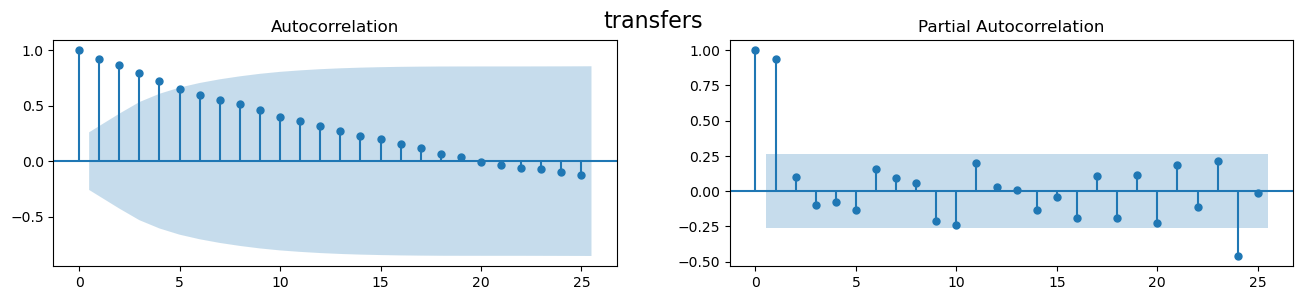

In [34]:
## Compute autocorrelation and partial correlation

# Personal
for i in df_personal.columns:
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    fig.suptitle(i, fontsize=16)
    plot_acf(df_personal[i].tolist(), lags=25, ax=axes[0])
    plot_pacf(df_personal[i].tolist(), lags=25, ax=axes[1])
    fig.show()

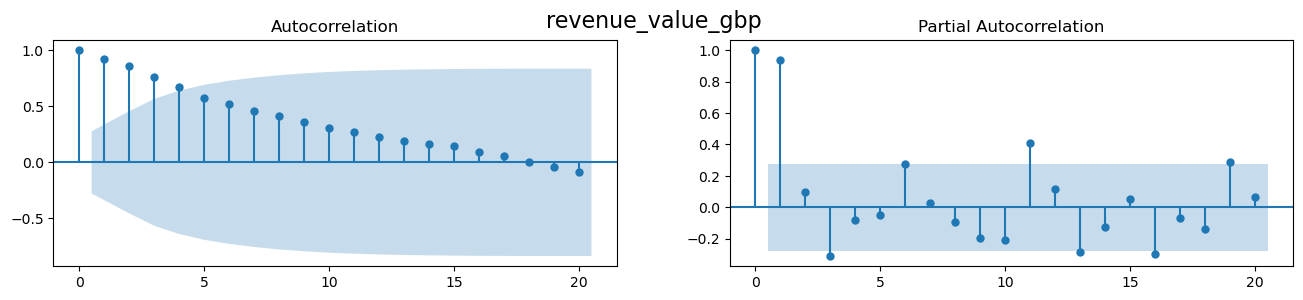

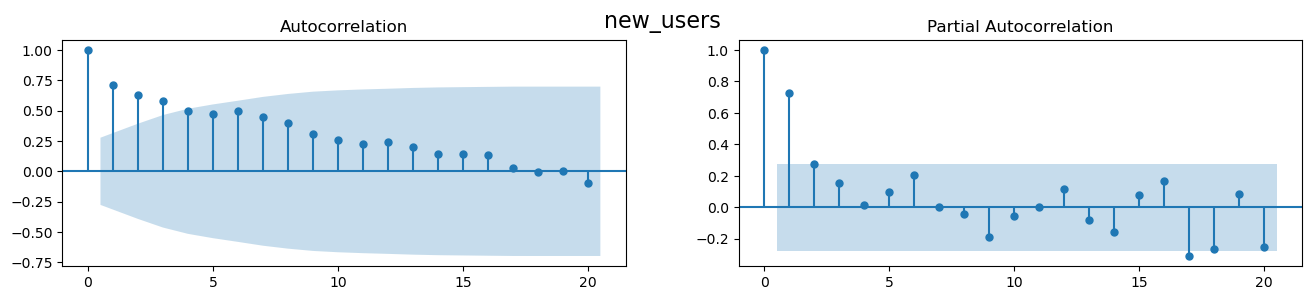

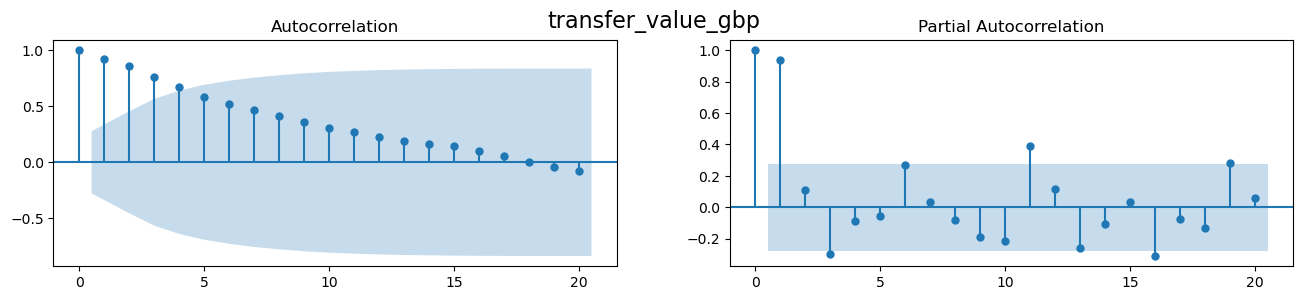

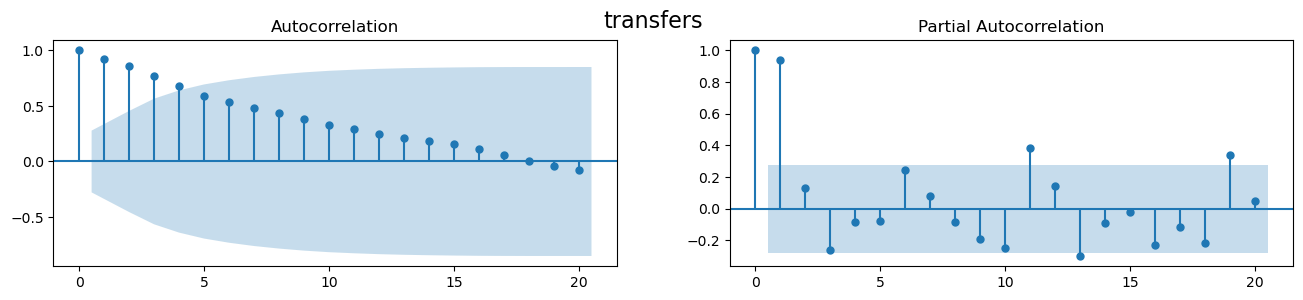

In [35]:
# Business
for i in df_business.columns:
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    fig.suptitle(i, fontsize=16)
    plot_acf(df_business[i].tolist(), lags=20, ax=axes[0])
    plot_pacf(df_business[i].tolist(), lags=20, ax=axes[1])
    fig.show()

Autocorrelation of the series is nothing but the correlation of the series with its previous values. If we take a look at the autocorrelation charts above, we can conclude:
- The features are highly correlated with their own lags up to the 10th lag.
- Excluding the correlation contributions from the intermediate lags (partial autocorrelation), most features have high autocorrelation on the 11th lag.

In [36]:
# Prepare data

def prepare_data(df,dif):
    
    # Differencing
    if dif == 1:
        for i in df.columns:
            df[i+'_diff'] = df[i] - df[i].shift(1)
    
    else:
        pass
    
    df = df.dropna().reset_index(drop=True)
    
    # Train-test split
    nobs = 12
    df_train, df_test = df[0:-nobs], df[-nobs:]
    
    # Normalize data
    scaler = StandardScaler() #MinMaxScaler() #
    train_scd = scaler.fit_transform(df_train)
    df_train_scd = (pd.DataFrame(train_scd, index=df_train.index, columns=df_train.columns))
    
    test_scd = scaler.transform(df_test)
    df_test_scd = (pd.DataFrame(test_scd, index=df_test.index, columns=df_test.columns))
    

    #return df_train,df_test, scaler
    return df_train_scd,df_test_scd, scaler

df_personal_train,df_personal_test,scaler_personal = prepare_data(df_personal,0)
df_business_train,df_business_test,scaler_business = prepare_data(df_business,0)

In [37]:
## Evaluation metrics

# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# Bias
def forecast_bias(expected, predictions): 
    forecast_errors = [expected[i]-predictions[i] for i in range(expected.index.min(), expected.index.max())]
    bias = sum(forecast_errors) * 1.0/len(expected)
    return bias

def model_data(df_train, df_test, scaler):

    # model fitting
    model = VAR(df_train)
    results = model.fit(maxlags=5, ic='aic')
    #print(results.summary())
    
    # forecasting
    lag_order = results.k_ar
    pred = results.forecast(df_test.values[-lag_order:], 12)
    
    # Reverse transformation
    pred_inv = scaler.inverse_transform(pred)
    pred = (pd.DataFrame(pred_inv, index=df_test.index, columns=df_test.columns + '_pred'))
    
    # plotting
    fig = results.plot_forecast(12)
    fig.tight_layout()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    #results.plot_forecast(12)
    
    
    # Reverse test set transformation
    test_inv = scaler.inverse_transform(df_test)
    df_test_inv = (pd.DataFrame(test_inv, index=df_test.index, columns=df_test.columns))    
    
    
    # Evaluate model
    df_eval = df_test_inv.merge(pred, how='inner', left_index=True, right_index=True)
    

    for i in df_test.columns:
        print('\n FEATURE: ',i)
        mape = mean_absolute_percentage_error(df_eval[i],df_eval[str(i)+'_pred'])
        mae = mean_absolute_error(df_eval[i],df_eval[str(i)+'_pred'])
        mse = mean_squared_error(df_eval[i],df_eval[str(i)+'_pred'])
        bias = forecast_bias(df_eval[i],df_eval[str(i)+'_pred'])

        print('Bias: %f' % bias)
        print('Mean absolute percentage error: %f' % mape)
        print('Mean absolute error:', mae)
        print('Mean squared error:', mse)    

    
    return df_eval


 FEATURE:  revenue_value_gbp
Bias: -67595.814234
Mean absolute percentage error: 48.773371
Mean absolute error: 76450.02869708215
Mean squared error: 6332381987.558911

 FEATURE:  new_users
Bias: -320.238690
Mean absolute percentage error: 48.328263
Mean absolute error: 369.92405797379996
Mean squared error: 156557.6791652257

 FEATURE:  transfer_value_gbp
Bias: -7967792.288698
Mean absolute percentage error: 49.792238
Mean absolute error: 8985564.646665724
Mean squared error: 87018494474024.89

 FEATURE:  transfers
Bias: -8393.903307
Mean absolute percentage error: 57.979089
Mean absolute error: 9438.127303638896
Mean squared error: 95151214.43279319


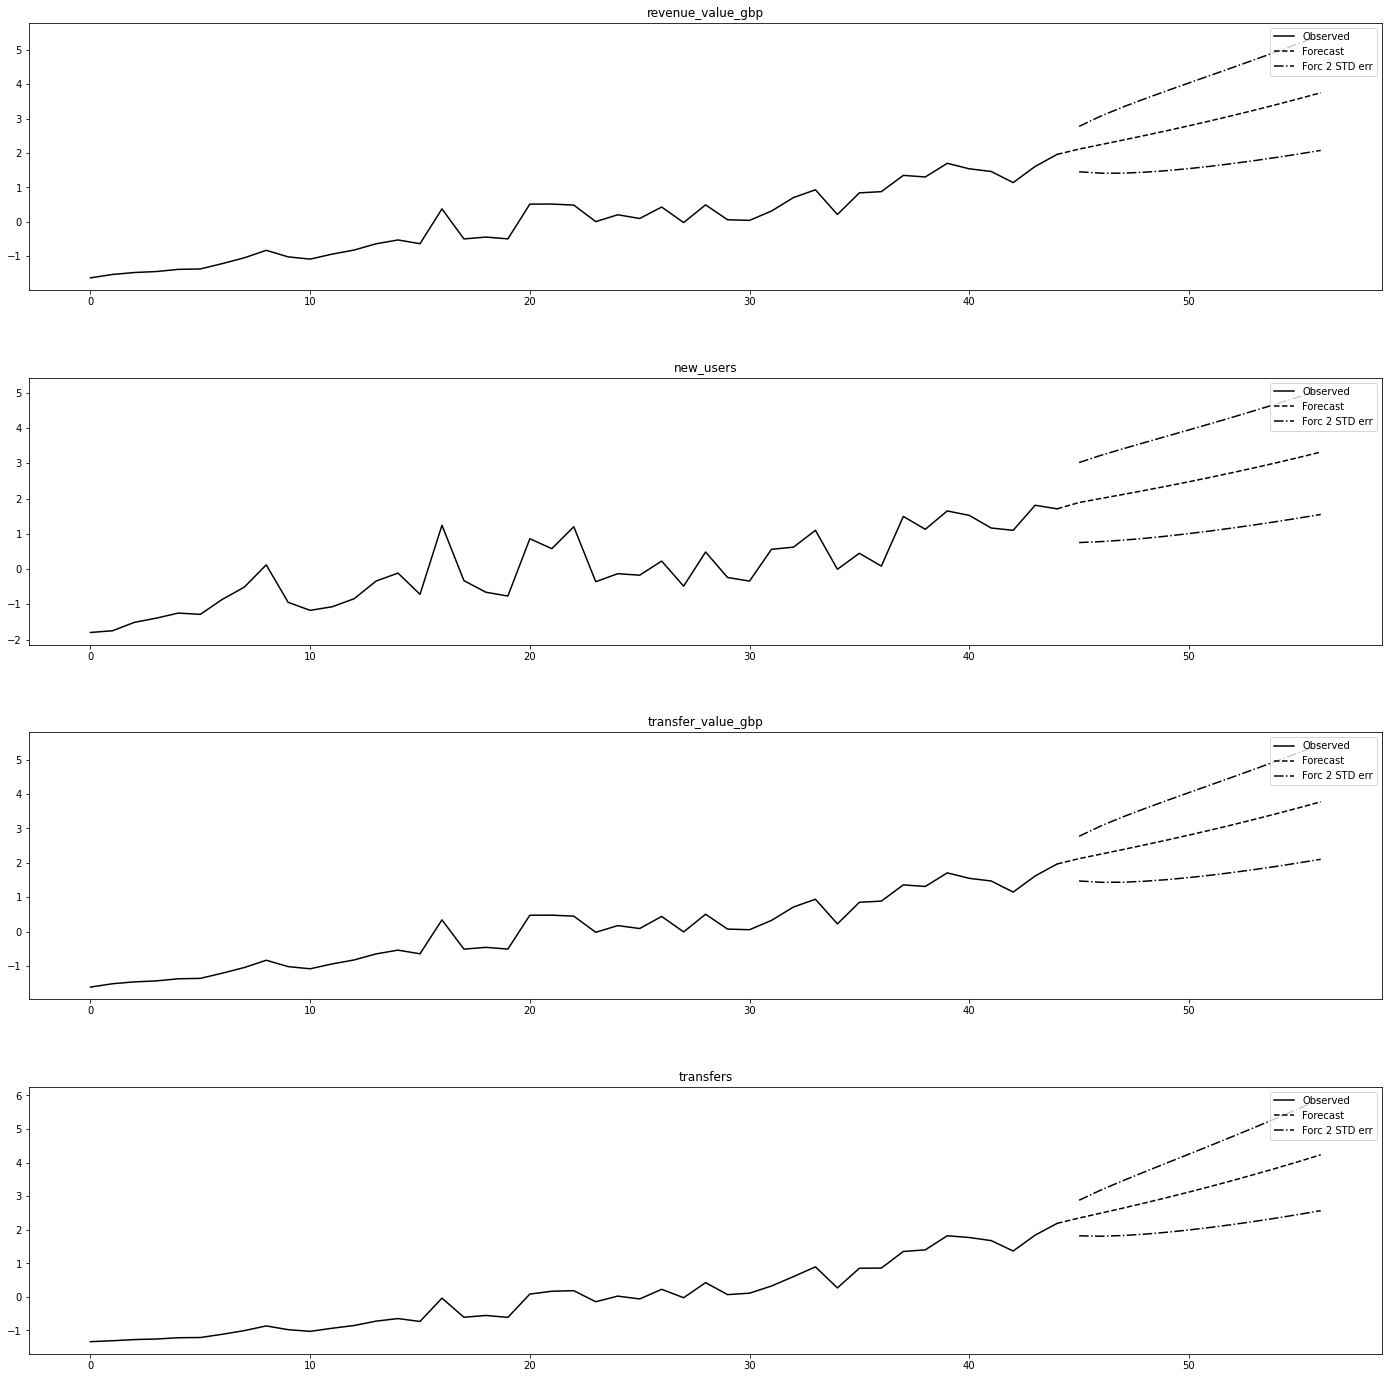

In [38]:
results_personal = model_data(df_personal_train,df_personal_test,scaler_personal)
#results_personal


 FEATURE:  revenue_value_gbp
Bias: -14748.608996
Mean absolute percentage error: 41.844345
Mean absolute error: 16512.876708106876
Mean squared error: 312837626.1338265

 FEATURE:  new_users
Bias: -20.002416
Mean absolute percentage error: 64.466260
Mean absolute error: 25.112305318750327
Mean squared error: 871.2978215868793

 FEATURE:  transfer_value_gbp
Bias: -1724257.706770
Mean absolute percentage error: 42.363929
Mean absolute error: 1924127.0891891278
Mean squared error: 4225260420447.15

 FEATURE:  transfers
Bias: -404.975816
Mean absolute percentage error: 54.066058
Mean absolute error: 447.9154654739486
Mean squared error: 218423.01524676022


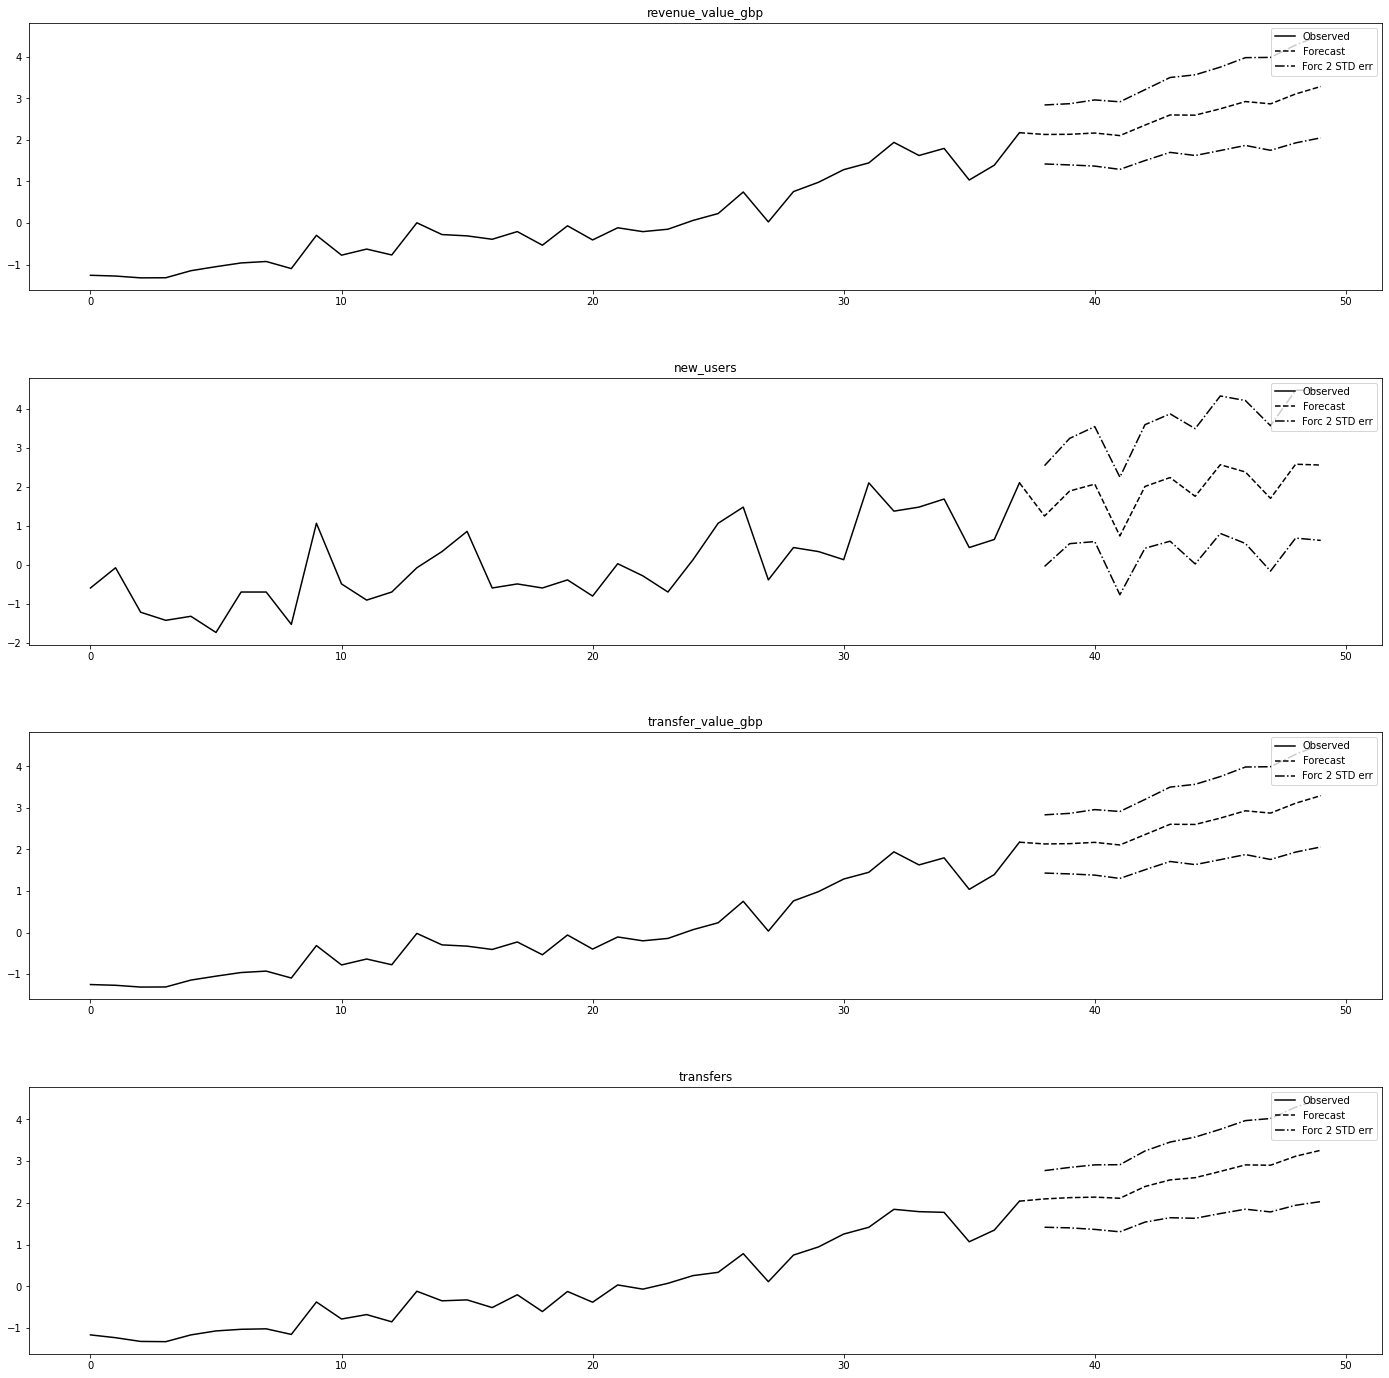

In [39]:
results_business = model_data(df_business_train,df_business_test,scaler_business)
#results_business

In [40]:
## Get final results
df_filtered_ = df_filtered.sort_values(by=['year_month'], ascending=True).reset_index(drop=True)
df_filtered_personal = df_filtered_[df_filtered_['transfer_type']=='Personal']
df_filtered_business = df_filtered_[df_filtered_['transfer_type']=='Business']

def get_forecast(df,results,retail_business):
    nobs = 12
    df_personal_res = df[0:-nobs][['year_month','transfer_value_gbp']][df['transfer_type']==retail_business]
    df_personal_res['type'] = 'Train'
    df_personal_res = df_personal_res.append(df[-nobs:][['year_month','transfer_value_gbp']][df['transfer_type']==retail_business])

    df_personal_res = df_personal_res.fillna('Test')


    results_personal_final = df[-nobs:][df['transfer_type']==retail_business][['year_month']].reset_index(drop=True).\
    merge(results.reset_index(drop=True), how='inner', left_index=True, right_index=True)

    results_personal_final['type'] = 'Forecast'

    df_personal_res = df_personal_res.append(results_personal_final[['year_month','transfer_value_gbp_pred','type']])

    return df_personal_res

final_output_personal = get_forecast(df_filtered_personal,results_personal,'Personal')
final_output_business = get_forecast(df_filtered_business,results_business,'Business')

In [41]:
def plot_forecast(df,head):

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['year_month'], 
                             y=df['transfer_value_gbp'],
                        name='Observed'))

    fig.add_trace(go.Scatter(x=df['year_month'], y=df['transfer_value_gbp_pred'],
                        name='Forecast'))
    
    fig.update_layout(title=head,
                   xaxis_title='Date',
                   yaxis_title='Volume of Transfers (GBP))')
    
    fig.show()


In [42]:
plot_forecast(final_output_personal,'Personal')
plot_forecast(final_output_business,'Business')